In [63]:
# pipenv install pandas plotly scikit-learn lightgbm bayesian-optimization ipykernel ipywidgets nbformat matplotlib
# No Mac, instalar biblioteca libomp: brew install libomp

# Importar bibliotecas
import pandas as pd
import numpy as np

# Visualização
import plotly.express as px
import matplotlib.pyplot as plt

# Configuracões
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.printoptions(suppress=True, precision=3)

# Machine Learning
from lightgbm import LGBMClassifier, early_stopping, plot_tree, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, \
                            ConfusionMatrixDisplay, log_loss

# Otimização Bayesiana
from bayes_opt import BayesianOptimization

### Carregar os dados

In [64]:
df_vinhos = pd.read_csv('./datasets/wine_data.csv')

### Visualizar Estrutura

In [ ]:
df_vinhos.info()

In [ ]:
# Visualizar primeiros registros
df_vinhos.head(10)

In [ ]:
# Visualizar últimos registros
df_vinhos.tail(10)

In [ ]:
# Estatisitcas descritivas
df_vinhos.describe()

### EDA

In [ ]:
# Distribuição das variáveis numéricas
numerical_cols = df_vinhos.drop(columns='quality').columns

# Visualizar distribuição das variáveis numéricas
for col in numerical_cols:
    fig = px.histogram(df_vinhos, x=col, nbins=20 ,title=f'Distribuição de {col}')
    fig.show()

In [ ]:
# Visualizar distribuição da variável target
df_count = df_vinhos['quality'].value_counts().reset_index()
df_count.columns = ['quality', 'contagem']

fig = px.bar(df_count, x='quality', y='contagem', title='Distribuição da variável target')
fig.show()

In [ ]:
# Analisando relação entre variáveis numéricas e target
for col in numerical_cols:
    fig = px.box(df_vinhos, x='quality', y=col, title=f'Relação entre {col} e quality')
    fig.show()

In [ ]:
# Matriz de Correlação
corr = df_vinhos.corr()

# Heatmap da matriz de correlação
fig = px.imshow(
  corr, 
  color_continuous_scale='armyrose', 
  title='Matriz de Correlação',
  zmin=-1,
  zmax=1
)

fig.update_traces(text=corr, texttemplate='%{text:.2f}', textfont_size=9)
fig.update_layout(
  width=1000,
  height=600,
  title_font=dict(size=14),
  font=dict(size=10),
)
fig.show()

### Preparação dos dados

In [73]:
# Separar X e Y
X = df_vinhos.drop(columns=['quality'], axis=1)
y = df_vinhos['quality']

In [74]:
# Separar entre Treino, Validação e Teste
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.5, random_state=51)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=51)

### Treinar modelo LightGBM usando Otimização Bayesiana

In [75]:
# Definir grade de hiperparâmetros a serem otimizados
grade_hiperparametros = {
  'num_leaves': (10, 100),
  'max_depth': (3, 15),
  'learning_rate': (0.01, 0.3),
  'min_data_in_leaf': (5, 50),
  'feature_fraction': (0.5, 0.8)
}

In [76]:
# Criar função para o modelo LightGBM
def lightgbm_evaluate(num_leaves, max_depth, learning_rate, min_data_in_leaf, feature_fraction):
  model = LGBMClassifier(
    num_leaves=int(num_leaves),
    max_depth=int(max_depth),
    learning_rate=learning_rate,
    min_data_in_leaf=int(min_data_in_leaf),
    feature_fraction=feature_fraction,
    n_estimators=100
  )

  # Treinar o modelo com early stopping
  model.fit(X_train, 
            y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='multi_logloss',
            callbacks=[early_stopping(5)],
  )

  # Métrica de avaliação
  best_score = model.best_score_['valid_0']['multi_logloss']

  return -best_score

In [ ]:
# Otimização Bayesiana
optimizer = BayesianOptimization(f=lightgbm_evaluate, pbounds=grade_hiperparametros, random_state=51)
optimizer.maximize(init_points=5, n_iter=2)

In [78]:
# Melhor combinação de hiperparâmetros
print("Melhores hiperparâmetros encontrados:", optimizer.max)

Melhores hiperparâmetros encontrados: {'target': np.float64(-1.3632796290151727), 'params': {'feature_fraction': np.float64(0.7263915175522024), 'learning_rate': np.float64(0.22132614082794025), 'max_depth': np.float64(9.777131264694447), 'min_data_in_leaf': np.float64(37.13546279353573), 'num_leaves': np.float64(62.412047249516874)}}


### Validar Resultados

In [ ]:
# Treinar modelo com melhores hiperparâmetros
best_params = optimizer.max['params']

best_model = LGBMClassifier(
  num_leaves=int(best_params['num_leaves']),
  max_depth=int(best_params['max_depth']),
  learning_rate=best_params['learning_rate'],
  min_data_in_leaf=int(best_params['min_data_in_leaf']),
  feature_fraction=best_params['feature_fraction'],
  n_estimators=100
)

# Treinar modelo
best_model.fit(X_train, y_train)

In [ ]:
# Fazer prediçoões
y_pred = best_model.predict(X_test)
y_pred

In [ ]:
# Fazer predições de probabilidade
y_pred_proba = best_model.predict_proba(X_test)
y_pred_proba

In [ ]:
# Relatório de classificação
print(classification_report(y_test, y_pred))

In [ ]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(cm, display_labels=best_model.classes_)
fig.plot()

In [ ]:
# Log Loss
log_loss(y_test, y_pred_proba)

### Interpretabilidade

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

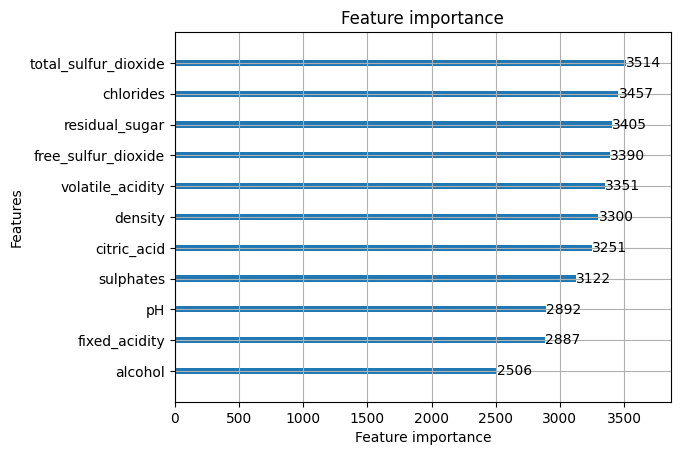

In [27]:
# Importancia das variáveis
plot_importance(best_model)

<Axes: >

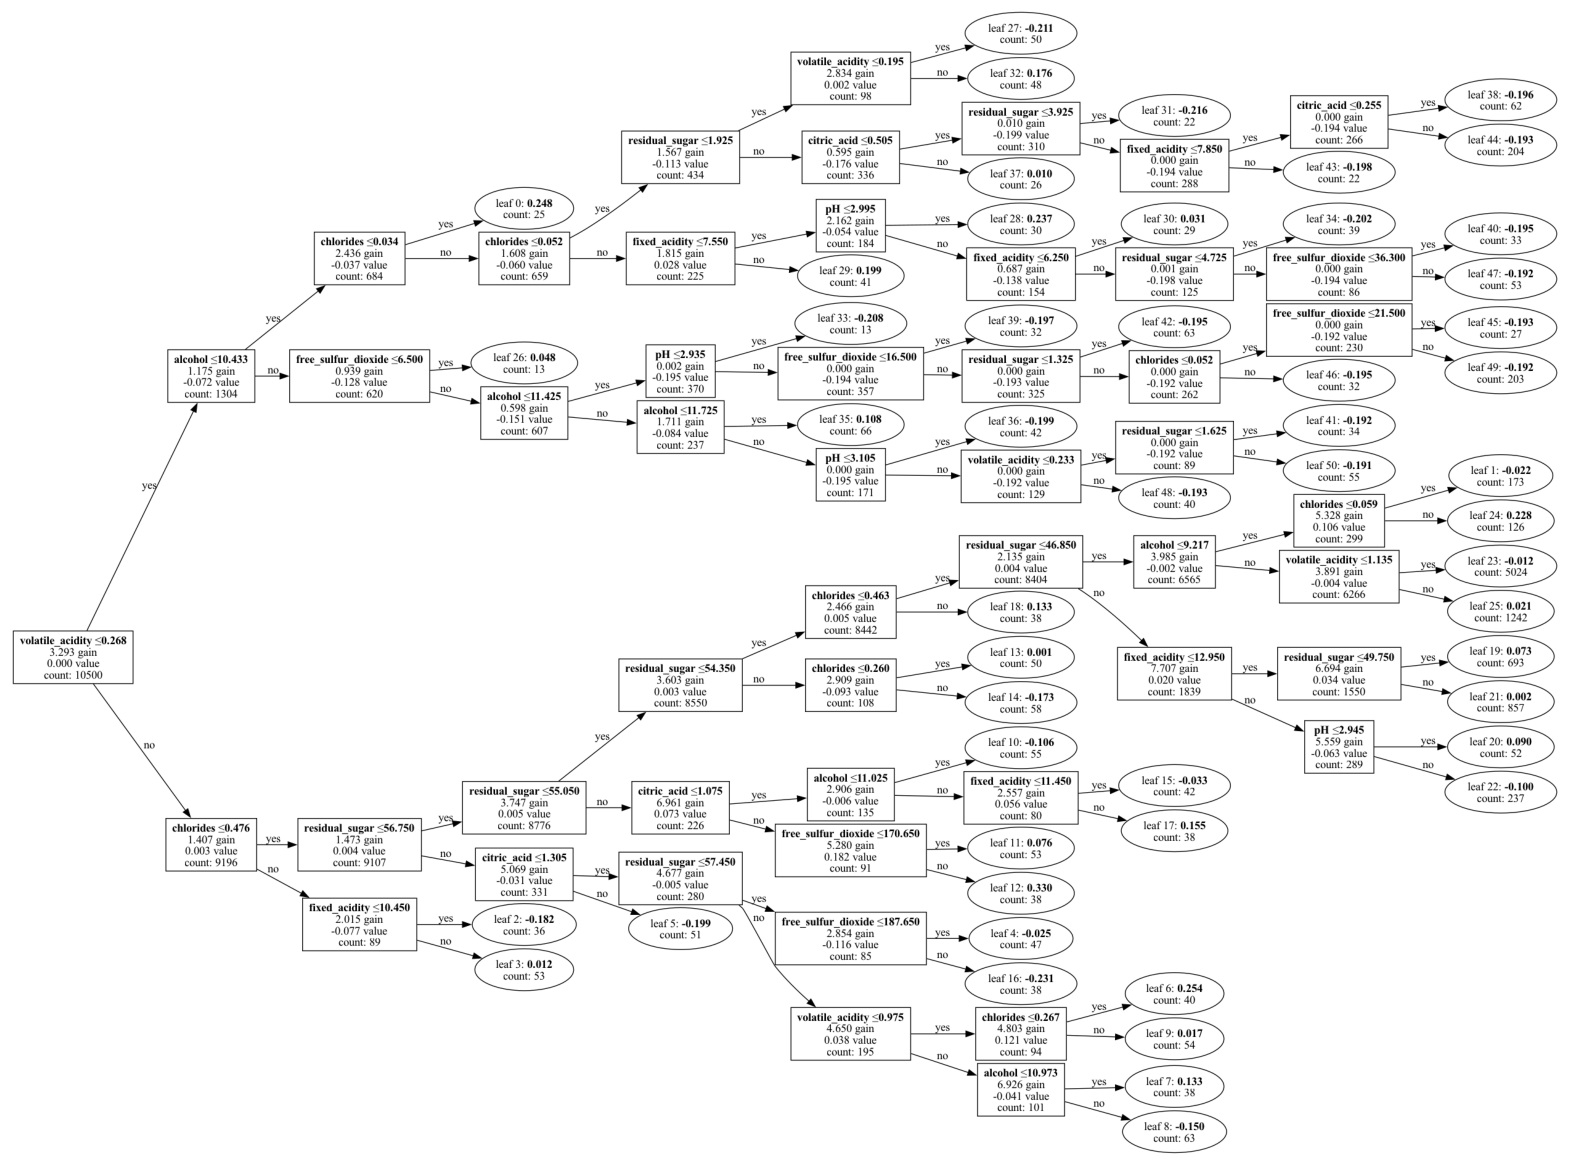

In [30]:
# Visualizar árvore de decisão
plot_tree(best_model, tree_index=99, figsize=(20, 20), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])